In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import periodogram
import pandas as pd
import csv
from physoce import tseries as ts
%matplotlib notebook

In [29]:
# load files .dat and .sen
file = 'SWCNO02.dat'
file2 = 'SWCNO02.sen'

In [30]:
# duplicate the rows in .sen file so time matches 2hrz sample rate 
df2 = pd.read_csv(file2, sep = '\s+', header = None)
df2 = np.array(df2)
df2 = np.repeat(df2,2,axis=0)
np.savetxt("sen2.csv",df2, delimiter=",",fmt='%s')
sen2 = 'sen2.csv'

In [31]:
# combine files
df = pd.read_csv(file, sep =  '\s+', names=["Burst_counter", "Ensemble_counter", "Velocity_East(m/s)", "Velocity_North(m/s)", 
"Velocity_Up(m/s)","Amplitude(Beam1)","Amplitude(Beam2) ","Amplitude(Beam3) ","SNR(Beam1)", "SNR(Beam2)","SNR(Beam3)","Correlation(Beam1)",
"Correlation(Beam2) ", "Correlation(Beam3) ", "Pressure","Analog_input_1","Analog_input_2", "Checksum"])

df2 = pd.read_csv(sen2, sep = ",", names=["Month", "Day", "Year", "Hour", "Minute", "Second", "Error", "Status", "volt", "SoundSpeed", "Heading", "Pitch", "Roll", "Temp", "Input", "Checksum"])
df3 = pd.concat([df, df2], axis=1) # Combine the two files


In [32]:
# Save combined file .csv
df3.to_csv('combined.csv')


In [55]:
Start_Time, End_Time =(1710,1714) # input start and end time ex: 10:45am - 1:05pm = 1045,1305

In [56]:
df3['Time']= (df3['Hour']*100)+ (df3['Minute']) #make new time column for indexing in military time

runindex = (df3['Time']>Start_Time-1) & (df3['Time']<End_Time+1) # index by start and end time
#convert pressure to depth (m). Equeation from Seabird http://www.seabird.com/document/an69-conversion-pressure-depth
Depth = ((((-1.82*10**-15 * df3['Pressure'] + 2.279*10**-10)* df3['Pressure'] - 2.2512*10**-5 ) * df3['Pressure'] + 9.72659) * df3['Pressure']) /9.80665

#df3.to_csv('combined.csv')


In [57]:
#define all variables of interest 
Mean_VN = np.mean(df3['Velocity_North(m/s)'][runindex])
Mean_VU = np.mean(df3['Velocity_Up(m/s)'][runindex])
Mean_VE = np.mean(df3['Velocity_East(m/s)'][runindex])
Max_VN = max(df3['Velocity_North(m/s)'][runindex])
Min_VN = min(df3['Velocity_North(m/s)'][runindex])
Max_VE = max(df3['Velocity_East(m/s)'][runindex])
Min_VE = min(df3['Velocity_East(m/s)'][runindex])
Max_VU = max(df3['Velocity_Up(m/s)'][runindex])
Min_VU = min(df3['Velocity_Up(m/s)'][runindex])
SD_VN = np.std(df3['Velocity_North(m/s)'][runindex])
SD_VU = np.std(df3['Velocity_Up(m/s)'][runindex])
SD_VE = np.std(df3['Velocity_East(m/s)'][runindex])
Mean_Depth = np.mean(Depth[runindex])
Max_Depth = max(Depth[runindex])
Min_Depth = min(Depth[runindex])
SD_Depth = np.std(Depth[runindex])
Day= (df2['Day'][1])
Month= (df2['Month'][1])
Year= (df2['Year'][1])




<IPython.core.display.Javascript object>


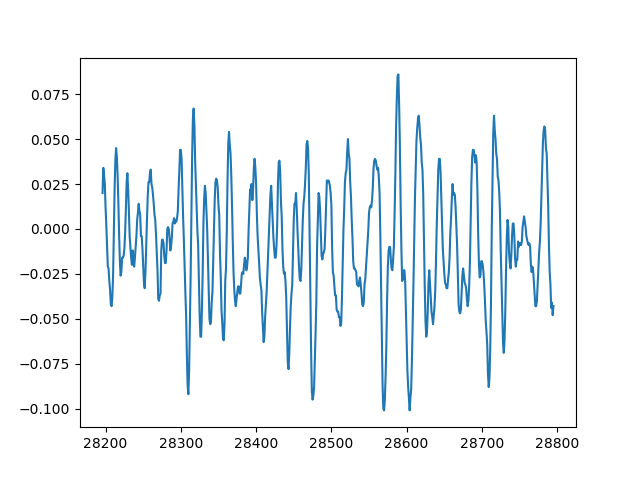

In [58]:
#check for anomalies 
plt.figure()
plt.plot(df3['Velocity_East(m/s)'][runindex])

In [59]:
#use PCA to rotate axis to make variable with most variation U
theta, major, minor=ts.princax(df3['Velocity_East(m/s)'][runindex], df3['Velocity_North(m/s)'][runindex]) #theta = angle, major = SD major axis, SD minor axis 
U, V= ts.rot(df3['Velocity_East(m/s)'][runindex], df3['Velocity_North(m/s)'][runindex], -theta)
SD_U = np.std(U)
SD_V = np.std(V)


[ 0.01994478  0.03388975  0.02981966  0.02480421  0.01185922  0.00198434
 -0.00999189 -0.02095255 -0.02203834 -0.02899912 -0.03403797 -0.04203773
 -0.04298309 -0.03796764 -0.0259446  -0.00194533  0.02203053  0.03804565
  0.04500643  0.03996758  0.02997568  0.01508536 -0.00283609 -0.01774202
 -0.02578858 -0.02384325 -0.0159137  -0.0159371  -0.01500734 -0.01107768
 -0.00214816  0.01082024  0.02582759  0.03085864  0.02191352  0.00991388
 -0.00409349 -0.01015572 -0.01606972 -0.0200306  -0.01196063 -0.01790584
 -0.02092915 -0.0159371  -0.0100153  -0.00407789  0.00487503  0.00885151
  0.01386696  0.00991388  0.00806217 -0.00393747 -0.00393747 -0.01089825
 -0.02091355 -0.02990547 -0.03292879 -0.02398367 -0.00910894  0.00487503
  0.01793704  0.02598361  0.02602261  0.03102246  0.0330302   0.02496023
  0.0229759   0.01899942  0.01400738  0.00806217  0.00503105 -0.00299211
 -0.01302301 -0.02307731 -0.03917044 -0.04029522 -0.03738113 -0.03647477
 -0.0124599  -0.00635867 -0.00620265 -0.00800756 -0

<IPython.core.display.Javascript object>


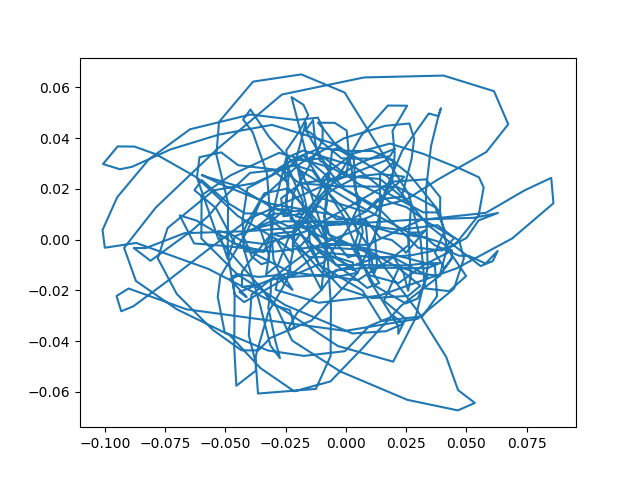

In [60]:
plt.figure()
plt.plot(U,V)

In [61]:
print(SD_U,SD_V) # this is what you want to use in master sheet " SD_U " 

0.0343810240847 0.0246080578966


In [62]:
# start putting all output into one sheet 
out = [Min_VU, Max_VU,Mean_VU,SD_VU,Min_VN,Max_VN,Mean_VN,SD_VN,Min_VE,
       Max_VE,Mean_VE,SD_VE,SD_U,Min_Depth,Max_Depth,Mean_Depth,SD_Depth,Month,Day,Year,Start_Time]
header = 'Min VU(m/s), Max VU(m/s), Mean VU(m/s), SD VU(m/s), Min VN(m/s), Max VN(m/s), Mean VN(m/s), SD VN(m/s), Min VE(m/s), Max VE(m/s), Mean VE(m/s), SD VE(m/s), SD_U(m/s), Min Depth(m), Max Depth(m), Mean Depth(m), SD Depth(m), Month, Day, Year, Start Time'
#output= pd.DataFrame[Mean_VN, Mean_VE, Mean_VU]

out2=np.array([out])

In [63]:
# save all veriables in new output .csv. Only use this for the first time stamp or it will override next time stamp
#np.savetxt("ADV_out_PCA.csv", out2, delimiter=",", fmt='%s', header=header)

In [64]:
# after first time stamp use this cell on runs i+1 ....i+inf to add to the same sheet as in cell 81
with open("ADV_out_PCA.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(out)